In [6]:
import numpy as np
import xgboost as xgb
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform
from pdb import set_trace

In [7]:
path = '/home/ec2-user/MLNotebooks/'

### Confusion matrix and individual class matrix function

In [8]:
def confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(8,4))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Cytosol', 'Mitochondria', 'Nuclear', 'Secretory']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    for i in range(len(classNames)):
        for j in range(len(classNames)):
            plt.text(j,i,str(cm[i][j]), ha='center', va='center')
    plt.show()

def making_ind_confusio_matrix(title, count, percent, accur, preci, sens, spec, f1):
    plt.figure(figsize=(2,2))
    plt.clf()
    plt.imshow(count, interpolation='none', cmap=plt.cm.Wistia)
    classNames = ['True', 'False']
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
  
    for i in range(len(classNames)):
        for j in range(len(classNames)):
            s = str(count[i][j]) + '\n' + str(percent[i][j])
            plt.text(j,i,s, ha='center', va='center')
    plt.text(1.8, 0.5, 
             f'Accuracy: {accur}\nPrecision: {preci}\nSensitivity: {sens}\nSpecificty: {spec}\nF1 Score: {f1}')
    plt.show()
    
def cytosol_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[0][0]
    FP = cm[1][0]+cm[2][0]+cm[3][0]
    FN = cm[0][1]+cm[0][2]+cm[0][3]
    TN = cm[1][1]+cm[1][2]+cm[1][3]+cm[2][1]+cm[2][2]+cm[2][3]+cm[3][1]+cm[3][2]+cm[3][3]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Cytosol', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)
    
def mito_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[1][1]
    FP = cm[0][1]+cm[2][1]+cm[3][1]
    FN = cm[1][0]+cm[1][2]+cm[1][3]
    TN = cm[0][0]+cm[0][2]+cm[0][3]+cm[2][0]+cm[2][2]+cm[2][3]+cm[3][0]+cm[3][2]+cm[3][3]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Mitochondria', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)

def nuclear_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[2][2]
    FP = cm[0][2]+cm[1][2]+cm[3][2]
    FN = cm[2][0]+cm[2][1]+cm[2][3]
    TN = cm[0][0]+cm[0][1]+cm[0][3]+cm[1][0]+cm[1][1]+cm[1][3]+cm[3][0]+cm[3][1]+cm[3][3]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Nucleus', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)

def secret_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[3][3]
    FP = cm[0][3]+cm[1][3]+cm[2][3]
    FN = cm[3][0]+cm[3][1]+cm[3][2]
    TN = cm[0][0]+cm[0][1]+cm[0][2]+cm[1][0]+cm[1][1]+cm[1][2]+cm[2][0]+cm[2][1]+cm[2][2]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Secretory', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)

### Krug Data processing

In [9]:
# load training dataset
train = pd.read_csv(path + 'Datasets/kr_ScrambledRow_0922.csv')

# drop index and gene column
train.drop(columns=['Unnamed: 0','Gene'],inplace=True)
print("Shape of complete dataframe:", train.shape)

# check target class and number
Counter(train['Localization'])

# assign independent variables as X and target as Y
X = train.drop(columns='Localization')
Y = train['Localization']

# encode target
Y = LabelEncoder().fit_transform(Y)

# sanity check to see numbers match and matching with previous counter to create target dictionary
print(Counter(train['Localization']))
print(Counter(Y))
target_dict = {'Cytosol':0, 'Mitochondria':1, 'Nuclear':2, 'Secretory':3}

# train-valid split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

# sanity check
for i in [X_train, X_val, y_train, y_val]:
    print(i.shape)

Shape of complete dataframe: (6173, 245)
Counter({'Cytosol': 2803, 'Nuclear': 1703, 'Secretory': 1204, 'Mitochondria': 463})
Counter({0: 2803, 2: 1703, 3: 1204, 1: 463})
(4938, 244)
(1235, 244)
(4938,)
(1235,)


### XGBClassiferModeling

In [10]:
# param search result 0523
{'gamma': 1, 'learning_rate': 0.03357156198163143, 
 'max_delta_step': 1, 'max_depth': 0, 'min_child_weight': 0.19696716116429006, 'num_parallel_tree': 2, 'subsample': 0.15295588065572036}

{'gamma': 1,
 'learning_rate': 0.03357156198163143,
 'max_delta_step': 1,
 'max_depth': 0,
 'min_child_weight': 0.19696716116429006,
 'num_parallel_tree': 2,
 'subsample': 0.15295588065572036}

In [5]:
# initate the model
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', seed=40)

# set up params
params = {'gamma': 1, 
          'learning_rate': 0.03357156198163143, 
          'max_delta_step': 1, 
          'max_depth': 0, 
          'min_child_weight': 0.19696716116429006, 
          'num_parallel_tree': 2, 
          'sampling_method': 'gradient_based',
          'subsample': 0.15295588065572036,
          'early_stopping_rounds': 10,
          'eval_metric': 'mlogloss',
          'n_estimators': 400, 
          'n_jobs': -1,
          'tree_method': 'gpu_hist'}

clf_xgb.set_params(**params)

# set up weights
train_weight = compute_sample_weight('balanced', y_train)
valid_weight = compute_sample_weight('balanced', y_val)

# train the model
clf_xgb.fit(X_train, y_train, verbose=20, eval_set=[(X_val, y_val)])


[0]	validation_0-mlogloss:1.38148
[20]	validation_0-mlogloss:1.30932
[40]	validation_0-mlogloss:1.27326
[60]	validation_0-mlogloss:1.25609
[80]	validation_0-mlogloss:1.25008
[100]	validation_0-mlogloss:1.24998
[104]	validation_0-mlogloss:1.25132


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03357156198163143, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=0, max_leaves=None,
              min_child_weight=0.19696716116429006, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=2, objective='multi:softmax', predictor=None, ...)

0.42591093117408907

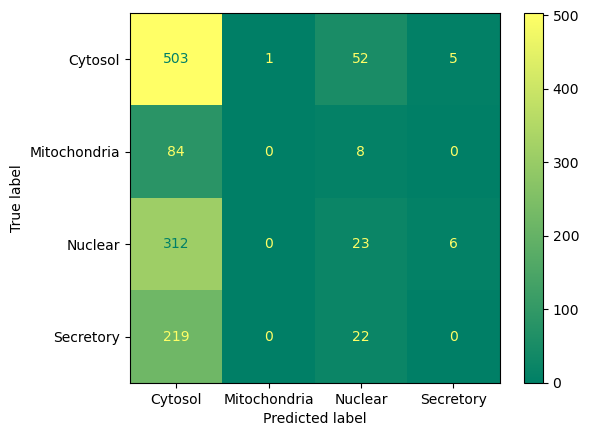

In [11]:
y_pred = clf_xgb.predict(X_val)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='summer', colorbar=True, display_labels=['Cytosol', 'Mitochondria', 'Nuclear', 'Secretory'])
accuracy_score(y_val, y_pred)

In [12]:
print(f'best score: {clf_xgb.best_score}')
print(f'best iteration: {clf_xgb.best_iteration}')
print(f'best number of tree limit: {clf_xgb.best_ntree_limit}')

best score: 1.2481805742028271
best iteration: 94
best number of tree limit: 190


In [13]:
# Define hyperparameters and their distributions
# params_list = {'gamma': randint(0, 5), 
#           'learning_rate': uniform(0.01, 0.1), 
#           'max_delta_step': randint(0,5), 
#           'max_depth': randint(0,5), 
#           'min_child_weight': uniform(0.1, 0.5), 
#           'num_parallel_tree': randint(1, 3), 
#           'subsample': uniform(0.1, 0.9),
#           }


# # Create RandomizedSearchCV object
# random_search = RandomizedSearchCV(clf_xgb, params_list, n_iter=10, scoring='accuracy', cv=5,
#                                   return_train_score=False)

# # Fit the RandomizedSearchCV object to the data
# random_search.fit(X_train, y_train, sample_weight=train_weight, verbose=False, eval_set=[(X_val, y_val)])

# # Print the best hyperparameters
# print(random_search.best_params_)

In [14]:
# search result
{'gamma': 1, 'learning_rate': 0.03357156198163143, 
 'max_delta_step': 1, 'max_depth': 0, 'min_child_weight': 0.19696716116429006, 'num_parallel_tree': 2, 'subsample': 0.15295588065572036}


{'gamma': 1,
 'learning_rate': 0.03357156198163143,
 'max_delta_step': 1,
 'max_depth': 0,
 'min_child_weight': 0.19696716116429006,
 'num_parallel_tree': 2,
 'subsample': 0.15295588065572036}

### Plot precision for each class

In [15]:
# Initialize DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Iteration', 'Train_Accuracy', 'Valid_Accuracy', 'Cyto_Precision', 'Mito_Precision', 'Nucl_Precision', 'Secr_Precision'])

for iteration in range(1, clf_xgb.best_iteration + 1):
    # Get the training and validation predictions and labels
    valid_pred = clf_xgb.predict(X_val, iteration_range=(0,iteration))
    train_pred = clf_xgb.predict(X_train, iteration_range=(0,iteration))
    
    # Calculate precision, recall, and F1 score
    train_accu = accuracy_score(y_train, train_pred)
    valid_accu = accuracy_score(y_val, valid_pred)
    valid_precision = precision_score(y_val, valid_pred, average=None) # return score of each class if avg=None
    cyto = valid_precision[0]
    mito = valid_precision[1]
    nucl = valid_precision[2]
    secr = valid_precision[3]

    #valid_recall = recall_score(y_val, valid_pred, average='weighted')
    #valid_f1 = f1_score(y_val, valid_pred, average='weighted')
    
    # Append metrics to DataFrame
    metrics_df.loc[iteration] = [iteration, train_accu, valid_accu, cyto, mito, nucl, secr]

# Print the metrics DataFrame
print(metrics_df)

/home/ec2-user/miniconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/miniconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/miniconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Iteration  Train_Accuracy  Valid_Accuracy  Cyto_Precision  Mito_Precision   
1         1.0        0.484609        0.379757        0.465359        0.068493  \
2         2.0        0.550830        0.378947        0.480432        0.075000   
3         3.0        0.595990        0.388664        0.463568        0.103448   
4         4.0        0.640745        0.393522        0.461449        0.133333   
5         5.0        0.658566        0.389474        0.450472        0.066667   
..        ...             ...             ...             ...             ...   
90       90.0        0.994937        0.428340        0.450402        0.000000   
91       91.0        0.995545        0.426721        0.450402        0.000000   
92       92.0        0.996355        0.427530        0.450717        0.000000   
93       93.0        0.996355        0.425911        0.447907        0.000000   
94       94.0        0.997367        0.428340        0.449688        0.000000   

    Nucl_Precision  Secr_Pr

### Feature importances inspection

In [ ]:
# Get feature importance
# importance = bst.get_score(importance_type='weight')
# 'weight' denotes the number of times a feature is used to split the data across all trees.

# Print feature importance
# print(importance)

# Plot feature importance
xgb.plot_importance(clf_xgb, max_num_features=30, importance_type='gain', show_values=False)
plt.show()

### K-fold validation

In [ ]:
# Define K-fold cross-validation
# epoch = 50
# cv_results = xgb.cv(params=param, dtrain=xg_train, nfold=5,
#                     num_boost_round=epoch, 
#                     early_stopping_rounds=10, as_pandas=True, seed=123)
# cv_stats = round(cv_results.mean(),4)

# # results printed
# print(f'Average of metrics of 5-fold validation for {epoch} epochs')
# print(f'training classification error rate: {cv_stats[0]} ({cv_stats[1]})')
# print(f'training multiclass logloss: {cv_stats[2]} ({cv_stats[3]})')
# print(f'validation classification error rate: {cv_stats[4]} ({cv_stats[5]})')
# print(f'validation multiclass logloss: {cv_stats[6]} ({cv_stats[7]})')

### Prediction and confusion matrices

              precision    recall  f1-score   support

     Cytosol       0.45      0.90      0.60       561
Mitochondria       0.00      0.00      0.00        92
     Nuclear       0.22      0.07      0.10       341
   Secretory       0.00      0.00      0.00       241

    accuracy                           0.43      1235
   macro avg       0.17      0.24      0.18      1235
weighted avg       0.26      0.43      0.30      1235

Macro avg = averaging the unweighted mean per label
Weighted avg = averaging the support-weighted mean per label


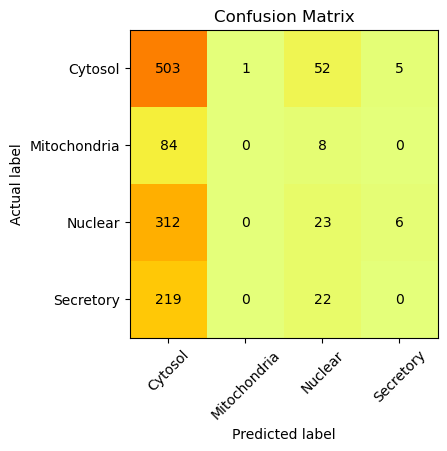

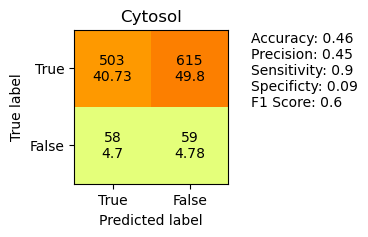

/tmp/ipykernel_18336/2319855179.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  f1_score = round((2/(1/precision + 1/sense)),2)


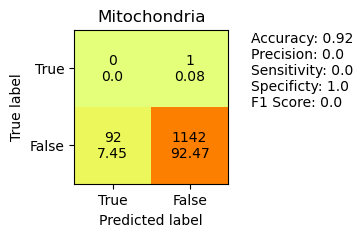

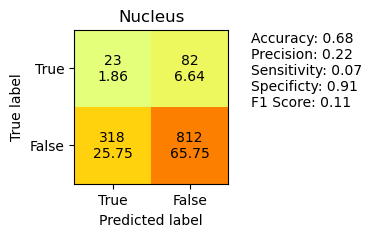

/tmp/ipykernel_18336/2319855179.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  f1_score = round((2/(1/precision + 1/sense)),2)


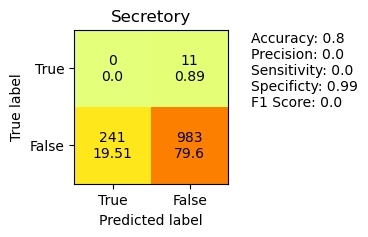

In [16]:
# get prediction
print(classification_report(y_val, y_pred, target_names=['Cytosol', 'Mitochondria', 'Nuclear', 'Secretory']))
print("Macro avg = averaging the unweighted mean per label\nWeighted avg = averaging the support-weighted mean per label")
# print confusion matr
confusio_matrix(y_val, y_pred)
cytosol_confusio_matrix(y_val, y_pred)
mito_confusio_matrix(y_val, y_pred)
nuclear_confusio_matrix(y_val, y_pred)
secret_confusio_matrix(y_val, y_pred)

### Figures

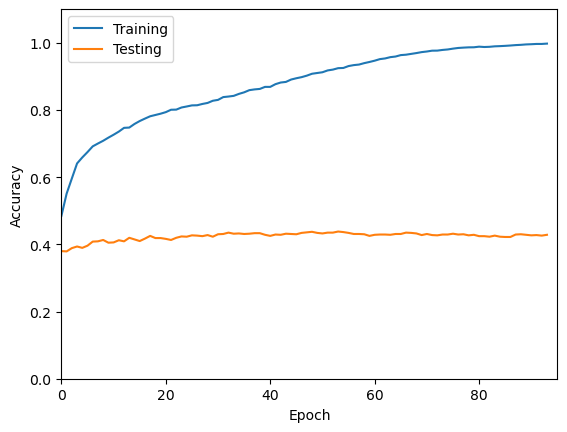

In [19]:
# plot accuracy
fig, ax = plt.subplots()
ax.plot(range(0, len(metrics_df)), metrics_df['Train_Accuracy'], label="Training")
ax.plot(range(0, len(metrics_df)), metrics_df['Valid_Accuracy'], label="Testing")
#ax.plot(range(0, len(metrics_df)), metrics_df['Cyto_Precision'], label="Cytosol")
#ax.plot(range(0, len(metrics_df)), metrics_df['Mito_Precision'], label="Mitochondria")
#ax.plot(range(0, len(metrics_df)), metrics_df['Nucl_Precision'], label="Nucleus")
#ax.plot(range(0, len(metrics_df)), metrics_df['Secr_Precision'], label="Secretory")

#ax.plot(range(0, len(metrics_df)), metrics_df['Valid Recall'], label="Recall")
#ax.plot(range(0, len(metrics_df)), metrics_df['Valid F1 Score'], label="F1 Score")
ax.legend()
plt.xlabel("Epoch")
plt.xlim([0, len(metrics_df)+1])
plt.ylim([0, 1.1])
plt.ylabel("Accuracy")
plt.show()
fig.savefig(path+"XGBoost/krug_scramblepatientorder_xgbclassifer_0923.pdf")